In [1]:
import pandas as pd
import numpy as np
import requests, time
from pathlib import Path
from datetime import datetime

from sklearn.metrics import mean_squared_error

from functions import *

%matplotlib inline

In [2]:
MSFT_df = pd.read_csv(
    Path('../data/stocks_history.csv'),
    index_col='Unnamed: 0',
    infer_datetime_format=True,
    parse_dates=True
)
dropped_columns = [
    'MSFT_open',
    'MSFT_high',
    'MSFT_low',
    'AMD_close',
    'AMD_open',
    'AMD_high',
    'AMD_low',
    'TSLA_close',
    'TSLA_open',
    'TSLA_high',
    'TSLA_low',
    'JNJ_close',
    'JNJ_open',
    'JNJ_high',
    'JNJ_low',
    'REGN_close',
    'REGN_open',
    'REGN_high',
    'REGN_low',
    'GILD_close',
    'GILD_open',
    'GILD_high',
    'GILD_low'
]
MSFT_df.drop(columns=dropped_columns, inplace=True)
MSFT_df.dropna(inplace=True)
MSFT_df.columns = ['Close']
MSFT_df.head()

,Close
2010-06-29,23.31
2010-06-30,23.01
2010-07-01,23.16
2010-07-02,23.27
2010-07-06,23.82


In [3]:
lstm_model_path = './models/JNJ_close_1lstm_model.h5'
feature_column = 0
target_column = 0
predictions_path = './results/20200715_MSFT_LSTM_results.csv'
window = 50
predictions_df = predict_prices(
    df=MSFT_df,
    window=window,
    target_col_number=target_column,
    feature_col_number=feature_column,
    model_path=lstm_model_path,
    predictions_path=predictions_path
)

In [4]:
predictions_df = predictions_df.loc['2020-01-02':,:]
predictions_df.columns = ['MSFT_actual', 'MSFT_lstm']
predictions_df.head()

,MSFT_actual,MSFT_lstm
2020-01-02,157.70,161.184555
2020-01-03,160.62,160.711563
2020-01-06,158.62,162.529968
2020-01-07,159.03,162.209641
2020-01-08,157.58,162.081100


***

In [5]:
MSFT_returns = MSFT_df.pct_change()
MSFT_returns.tail()

,Close
2020-06-30,0.025549
2020-07-01,0.005847
2020-07-02,0.007621
2020-07-06,0.021526
2020-07-07,-0.011628


In [6]:
import pickle
regression_model_path = '../Steffen/pickle_regression_model.pkl'
regression_model = pickle.load(open(regression_model_path, 'rb'))
regression_df = regression_model.predict(MSFT_returns.loc['2020-01-02':,:])
regression_df = pd.DataFrame(regression_df, index=MSFT_returns.loc['2020-01-02':,:].index, columns=['MSFT_regression'])
regression_df.tail()

/Users/touficlawand/opt/anaconda3/envs/algotrading/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LinearRegression from version 0.22.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


,MSFT_regression
2020-06-30,-0.009086
2020-07-01,0.000107
2020-07-02,-0.000720
2020-07-06,-0.007209
2020-07-07,0.008261


In [7]:
cumulative_df = (regression_df['MSFT_regression'] + 1).cumprod() - 1
cumulative_df.tail()

2020-06-30    0.203350
2020-07-01    0.203478
2020-07-02    0.202611
2020-07-06    0.193942
2020-07-07    0.203805
Name: MSFT_regression, dtype: float64

In [10]:
regression_prices_df = pd.DataFrame(
    data=((1 + cumulative_df) * (MSFT_df.loc['2020-01-02','Close'])),
    columns=['MSFT_regression'],
    index=MSFT_df.index
)
regression_prices_df.tail()

,MSFT_regression
2020-06-30,193.282023
2020-07-01,193.302716
2020-07-02,193.163443
2020-07-06,191.770945
2020-07-07,193.355219


In [52]:
MSFT_df['MSFT_return'] = MSFT_df['Close'].pct_change() 
MSFT_df['MSFT_lagged_return'] = MSFT_df['MSFT_return'].shift()

In [53]:
# weeks = MSFT_df.index.to_period("w").unique()
# print(weeks[0])

2010-06-28/2010-07-04


In [54]:
# print(len(weeks))

524


In [55]:
# training_window = 50
# timeframe = len(weeks) - training_window - 1
# print(timeframe)

473


In [56]:
# all_predictions = pd.DataFrame(columns=["Out-of-Sample Predictions"])
# all_actuals = pd.DataFrame(columns=["Actual Returns"])

In [57]:
# for i in range(0, timeframe):
    
#     # Beginning of training window
#     start_of_training_period = weeks[i].start_time.strftime(format="%Y-%m-%d")
    
#     # End of training window
#     end_of_training_period = weeks[training_window+i].end_time.strftime(format="%Y-%m-%d")

#     # Window of test-window data
#     test_week = weeks[training_window + i + 1]
    
#     # String of testing window
#     start_of_test_week  = test_week.start_time.strftime(format="%Y-%m-%d")
#     end_of_test_week = test_week.end_time.strftime(format="%Y-%m-%d")
    
#     train = MSFT_df.loc[start_of_training_period:end_of_training_period]
#     test = MSFT_df.loc[start_of_test_week:end_of_test_week]
    
#     # Create new dataframes:
#     X_train = train["MSFT_lagged_return"].to_frame()
#     y_train = train["MSFT_return"]
#     X_test = test["MSFT_lagged_return"].to_frame()
#     y_test = test["MSFT_return"]

# #     model = LinearRegression()
# #     model.fit(X_train, y_train)
#     predictions = regression_model.predict(X_test)
    
#     # Create a temporary dataframe to hold predictions
#     predictions = pd.DataFrame(predictions, index=X_test.index, columns=["Out-of-Sample Predictions"])
    
#     # Create a temporary DataFrame of the actual "y"s in the test dataframe, with column name="Actual Returns": 
#     actuals = pd.DataFrame(y_test, index=y_test.index)
#     actuals.columns = ["Actual Returns"]  
    
#     # Append these two dataframes (predictions and actuals) to the two master DataFrames built outside the loop
#     all_predictions = all_predictions.append(predictions)
#     all_actuals = all_actuals.append(actuals)

In [58]:
# Results = pd.concat([all_actuals, all_predictions], axis=1)
# Results.head()

,Actual Returns,Out-of-Sample Predictions
2011-06-20,0.008656,-0.002318
2011-06-21,0.011851,-0.001204
2011-06-22,-0.004443,-0.002694
2011-06-23,-0.000811,0.004909
2011-06-24,-0.013398,0.003214


In [66]:
# results_2020 = Results.loc['2020':]
# results_2020.head()

,Actual Returns,Out-of-Sample Predictions
2020-01-02,0.018516,0.002510
2020-01-03,-0.012452,-0.005804
2020-01-06,0.002585,0.008646
2020-01-07,-0.009118,0.001629
2020-01-08,0.015928,0.007090


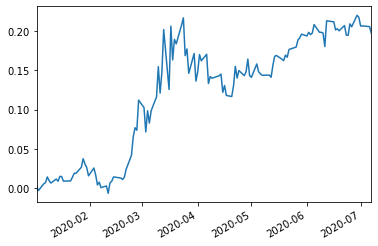

In [67]:
# cumulative_returns = (1 + results_2020['Out-of-Sample Predictions']).cumprod() - 1
# cumulative_returns.plot()

In [71]:
# cumulative_returns.tail()

2020-06-30    0.217432
2020-07-01    0.206370
2020-07-02    0.206499
2020-07-06    0.205630
2020-07-07    0.196938
Name: Out-of-Sample Predictions, dtype: float64

In [69]:
# results_2020_divided = (results_2020['Out-of-Sample Predictions']/100)
# cumulative_returns_divided = (results_2020_divided + 1).cumprod()-1
# prices = (cumulative_returns_divided +1) * (MSFT_df.loc['2020-01-02','Close'])
# prices.hvplot()

:Curve   [index]   (Out-of-Sample Predictions)

In [70]:
# regression_path = '../Steffen/Linear Regression Results.csv'
# regression_df = pd.read_csv(
#     Path(regression_path),
#     index_col='Unnamed: 0',
#     parse_dates=True,
#     infer_datetime_format=True
# )
# regression_df.columns = ['MSFT_regression']
# regression_df.head()

In [63]:
combined_df = pd.merge(predictions_df, regression_df, how='inner', left_index=True, right_index=True)

In [64]:
combined_df.head()

,MSFT_actual,MSFT_lstm,Close,MSFT_regression
2020-01-02,157.70,161.184555,NaN,NaN
2020-01-03,160.62,160.711563,NaN,NaN
2020-01-06,158.62,162.529968,NaN,NaN
2020-01-07,159.03,162.209641,NaN,NaN
2020-01-08,157.58,162.081100,NaN,NaN


***

In [65]:
import hvplot.pandas
combined_df.hvplot(width=1200, height=600)

:NdOverlay   [Variable]
   :Curve   [index]   (value)